In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from pyspark.sql import SparkSession  # For SQL over pandas.DataFrame

## Loading and preocessing

In [ ]:
data = pd.read_csv('/content/Fertility2.csv')
data.columns

Index(['rownames', 'morekids', 'gender1', 'gender2', 'age', 'afam', 'hispanic',
       'other', 'work'],
      dtype='object')

In [ ]:
data.head()

,rownames,morekids,gender1,gender2,age,afam,hispanic,other,work
0,1,no,female,female,35,no,no,no,40
1,2,no,female,male,33,no,no,no,52
2,3,no,female,female,28,no,no,no,12
3,4,no,male,male,28,no,no,no,0
4,5,no,female,male,31,no,no,no,0


In [ ]:
X = data[['gender1', 'gender2', 'age', 'afam', 'hispanic', 'other']]
y = data['morekids']

In [ ]:
spark = SparkSession.builder.appName('SQLonDataFrame').getOrCreate()

In [ ]:
df = spark.createDataFrame(data)
df.createOrReplaceTempView('data')
spark.sql("desc data").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|rownames|   bigint|   NULL|
|morekids|   string|   NULL|
| gender1|   string|   NULL|
| gender2|   string|   NULL|
|     age|   bigint|   NULL|
|    afam|   string|   NULL|
|hispanic|   string|   NULL|
|   other|   string|   NULL|
|    work|   bigint|   NULL|
+--------+---------+-------+



## Data Munging

In [ ]:
# Count number of rows with any NULL value
q = \
'''select count(*) from data
where morekids=NULL or gender1=NULL or gender2=NULL
  or age=NULL or afam=NULL or hispanic=NULL or other=NULL'''
spark.sql(q).show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [ ]:
# Count number of rows with inconsistent value for gender2
q = \
'''select * from data
where gender2 not in ('male', 'female')'''
spark.sql(q).show()

+--------+--------+-------+-------+---+----+--------+-----+----+
|rownames|morekids|gender1|gender2|age|afam|hispanic|other|work|
+--------+--------+-------+-------+---+----+--------+-----+----+
+--------+--------+-------+-------+---+----+--------+-----+----+



In [ ]:
# Replace 'yes', 'male'->1, 'no', 'female'->0 to convert to integer data
q = \
'''select
case when gender1='female' then 0 else 1 end as gender1,
case when gender2='female' then 0 else 1 end as gender2,
age,
case when afam='no' then 0 else 1 end as afam,
case when hispanic='no' then 0 else 1 end as hispanic,
case when other='no' then 0 else 1 end as other,
case when morekids='no' then 0 else 1 end as morekids,
work
from data'''
newData = spark.sql(q)
newData.show(5)

# Creates new View 'newData' in the SparkSQL engine
newData.createOrReplaceTempView('newData')

+-------+-------+---+----+--------+-----+--------+----+
|gender1|gender2|age|afam|hispanic|other|morekids|work|
+-------+-------+---+----+--------+-----+--------+----+
|      0|      0| 35|   0|       0|    0|       0|  40|
|      0|      1| 33|   0|       0|    0|       0|  52|
|      0|      0| 28|   0|       0|    0|       0|  12|
|      1|      1| 28|   0|       0|    0|       0|   0|
|      0|      1| 31|   0|       0|    0|       0|   0|
+-------+-------+---+----+--------+-----+--------+----+
only showing top 5 rows



In [ ]:
newData.toPandas().to_csv('Fertility2_preprocessed.csv')

In [ ]:
# Find average and std. dev. for all values
q = \
'''select
round(avg(gender1), 2) as gender1,
round(avg(gender2), 2) as gender2,
round(avg(age), 2) as age,
round(avg(afam), 2) as afam,
round(avg(hispanic), 2) as hispanic,
round(avg(other), 2) as other,
round(avg(work), 2) as work,
round(avg(morekids), 2) as morekids
from newData'''

In [ ]:
q = \
'''desc newData'''
spark.sql(q).show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
| gender1|      int|   NULL|
| gender2|      int|   NULL|
|     age|   bigint|   NULL|
|    afam|      int|   NULL|
|hispanic|      int|   NULL|
|   other|      int|   NULL|
|morekids|      int|   NULL|
|    work|   bigint|   NULL|
+--------+---------+-------+



In [ ]:
# Find percentage of families that identify as other wanting to have more kids
q = \
'''select round(100 * avg(morekids), 2) as percent_other_wanting_more_kids
from newData
where other = 1'''
spark.sql(q).show()

+-------------------------------+
|percent_other_wanting_more_kids|
+-------------------------------+
|                          45.57|
+-------------------------------+



## Clustering

In [ ]:
df = newData.toPandas()

In [ ]:
X = df.drop('morekids', axis=1)
y = df['morekids']

In [ ]:
print(X.shape, y.shape)

(30000, 7) (30000,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

# --- Clustering ---

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=100, n_init=10, max_iter=10)
pred = kmeans.fit_predict(X_scaled)
df['cluster'] = pred

# --- Analysis and "Prediction" ---

# See how 'morekids' is distributed in each cluster
cluster_crosstab = pd.crosstab(df['cluster'], df['morekids'])
print("Distribution of 'morekids' within each cluster:")
print(cluster_crosstab)
print()

# "Predict" 'morekids' based on the majority class in each cluster
cluster_0_majority = cluster_crosstab.loc[0].idxmax()
cluster_1_majority = cluster_crosstab.loc[1].idxmax()

predictions = df['cluster'].apply(lambda x: cluster_0_majority if x == 0 else cluster_1_majority)

# --- Evaluation ---
print(classification_report(y, predictions))

Distribution of 'morekids' within each cluster:
morekids      0      1
cluster               
0         17744  10551
1           928    777

              precision    recall  f1-score   support

           0       0.62      1.00      0.77     18672
           1       0.00      0.00      0.00     11328

    accuracy                           0.62     30000
   macro avg       0.31      0.50      0.38     30000
weighted avg       0.39      0.62      0.48     30000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualization after PCA

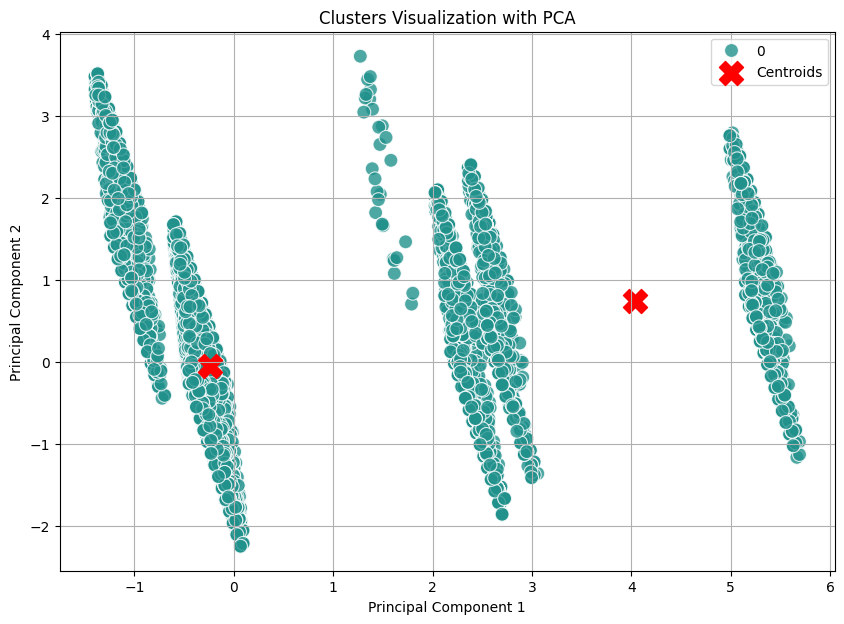

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce dimensions for plotting using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = predictions

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)

# Plot the centroids
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('Clusters Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## Stop Spark Session

In [ ]:
spark.stop()